In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [6]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = "/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1"

sub_ids = load_participant_list(base_dir)
sub_ids = sub_ids[:20]

In [7]:
subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]

/Users/hugofluhr/phd_local/repositories/RewardPairsTask_Analysis/notebooks/../utils/data.py:166: UserWarning: Last 1 trial(s) of block had no response, filling with 0


# Setting parameters

In [8]:
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'basic'

run = 'learning1'


# Get the data

In [9]:
# ref to the block
blocks = [getattr(subject, run) for subject in subjects]
events = [block.events for block in blocks]

In [10]:
img_paths = [subject.img.get(run) for subject in subjects]
fmri_imgs = [image.load_img(img_path) for img_path in img_paths]

In [11]:
confounds, sample_mask  = zip(*[subject.load_confounds(run, motion_type=motion_type) for subject in subjects])

# First Level Models

In [12]:
n = fmri_imgs[0].shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [13]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")

X1s = [make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)
        for events, confounds in zip(events, confounds)]

In [14]:
model1 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm)
model_fits = [model1.fit(fmri_img, design_matrices=X1, sample_masks=sample_mask)
              for fmri_img, X1, sample_mask in zip(fmri_imgs, X1s, sample_mask)]

In [15]:
#plot_design_matrix(X1s[0])  

In [16]:
z_maps_response = [model_fit.compute_contrast('response', output_type='z_score')
                   for model_fit in model_fits]

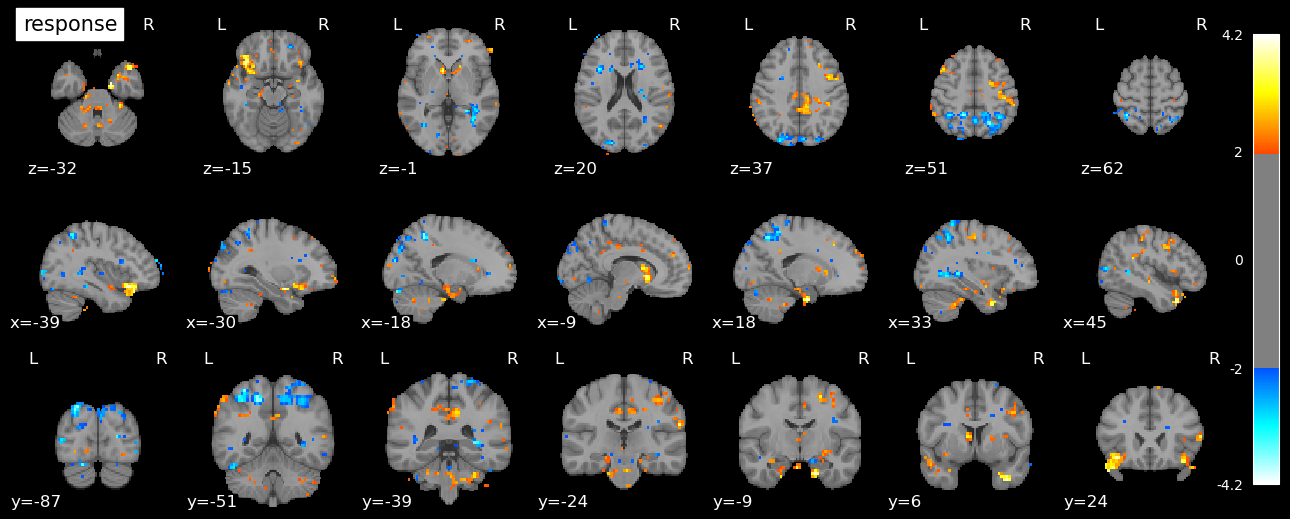

In [17]:
# plot an example z-map
plot_stat_map(z_maps_response[0], threshold=2, display_mode='mosaic', black_bg=True, title='response')

# Average image

In [18]:
from nilearn.image import math_img

In [19]:
avg_z_map = math_img("np.mean(imgs, axis=3)", imgs=z_maps_response)

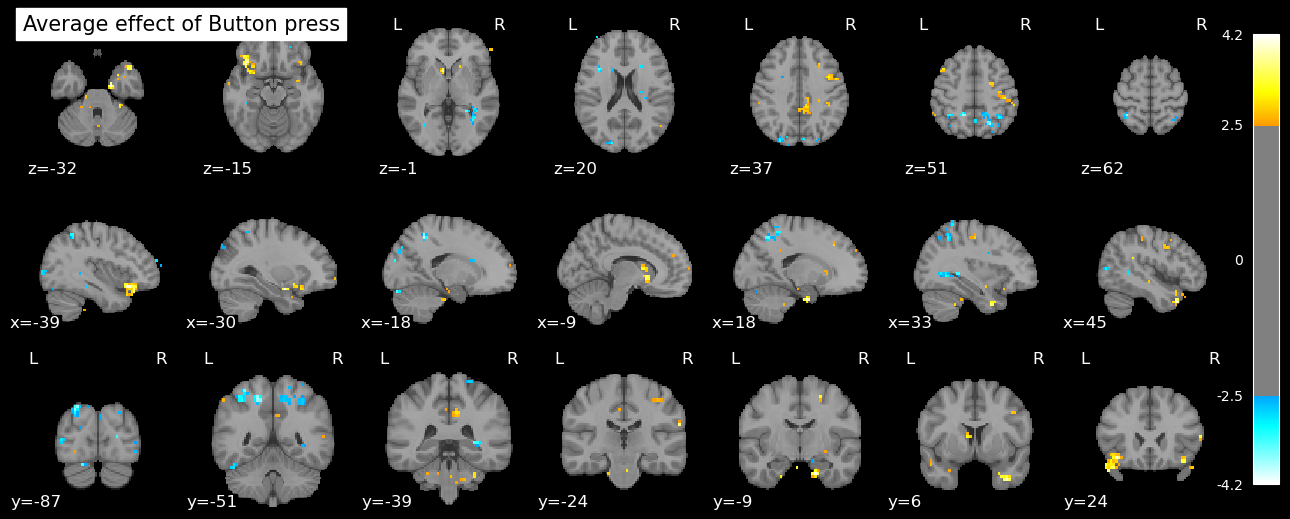

In [28]:
plot_stat_map(avg_z_map, threshold=2.5, black_bg=True, display_mode='mosaic', title='Average effect of Button press')


# Second level

In [29]:
X_response = pd.DataFrame([1] * len(z_maps_response), columns=['Intercept'])

In [30]:
model2 = SecondLevelModel()
model2 = model2.fit(z_maps_response, design_matrix=X_response)

In [31]:
response_map = model2.compute_contrast('Intercept',output_type='z_score')

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/_utils.py:205: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1.0 / X)


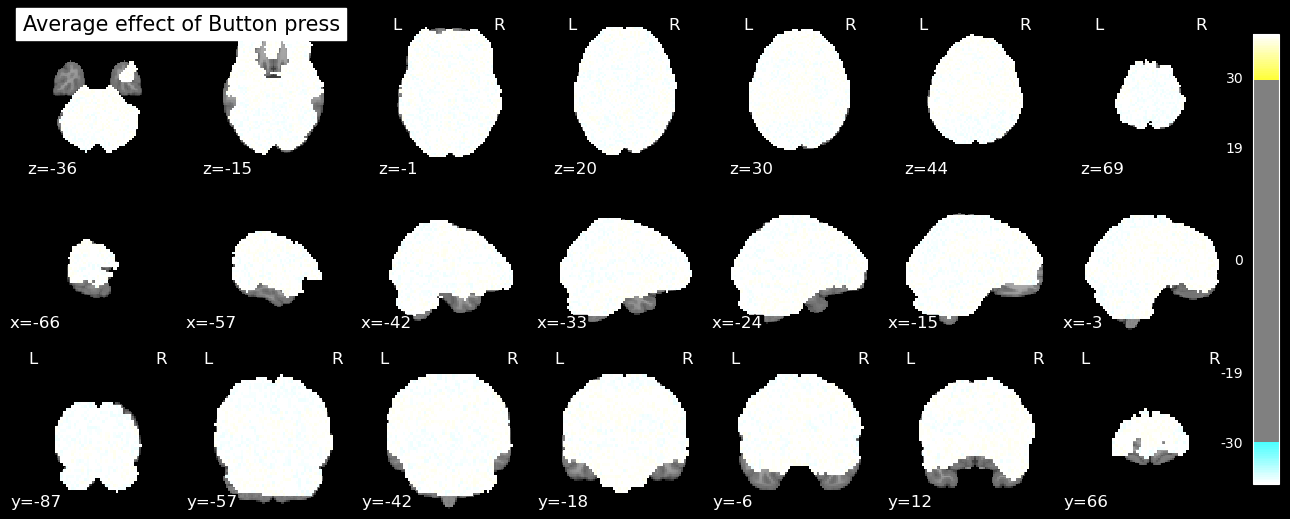

In [23]:
plot_stat_map(response_map, threshold=30, black_bg=True, display_mode='mosaic', title='Average effect of Button press')

In [24]:
plt.hist(z_maps_response[4].get_fdata().ravel(), bins=100, color='black');

NameError: name 'plt' is not defined